In [1]:
from os import listdir
from os.path import isdir, join
import librosa
import random
import numpy as np
import matplotlib.pyplot as plt
import python_speech_features

In [24]:
# Dataset path and view possible targets
dataset_path = 'Rec'
for name in listdir(dataset_path):
    if isdir(join(dataset_path, name)):
        print(name)

Bom Kanan
Bom Kiri
Hidup
Jalan Kanan
Jalan Kiri
Lompat
Melompat Kanan
Melompat Kiri
Nunduk
Tembak Atas
Tembak Kanan
Tembak Kiri
Tembak Nunduk


In [25]:
# Create an all targets list
all_targets = [name for name in listdir(dataset_path) if isdir(join(dataset_path, name))]
print(all_targets)

['Bom Kanan', 'Bom Kiri', 'Hidup', 'Jalan Kanan', 'Jalan Kiri', 'Lompat', 'Melompat Kanan', 'Melompat Kiri', 'Nunduk', 'Tembak Atas', 'Tembak Kanan', 'Tembak Kiri', 'Tembak Nunduk']


In [26]:
# See how many files are in each
num_samples = 0
for target in all_targets:
    print(len(listdir(join(dataset_path, target))))
    num_samples += len(listdir(join(dataset_path, target)))
print('Total samples:', num_samples)

3
3
3
3
3
3
3
3
3
3
3
3
3
Total samples: 39


In [531]:
# Settings
target_list = all_targets
feature_sets_file = 'all_targets_mfcc_sets.npz'
perc_keep_samples = 1.0 # 1.0 is keep all samples
val_ratio = 0.5
test_ratio = 0.4
sample_rate = 8000
num_mfcc = 96
len_mfcc = 96

In [532]:
# Create list of filenames along with ground truth vector (y)
filenames = []
y = []
for index, target in enumerate(target_list):
    print(join(dataset_path, target))
    filenames.append(listdir(join(dataset_path, target)))
    y.append(np.ones(len(filenames[index])) * index)

Rec\Bom Kanan
Rec\Bom Kiri
Rec\Hidup
Rec\Jalan Kanan
Rec\Jalan Kiri
Rec\Lompat
Rec\Melompat Kanan
Rec\Melompat Kiri
Rec\Nunduk
Rec\Tembak Atas
Rec\Tembak Kanan
Rec\Tembak Kiri
Rec\Tembak Nunduk


In [533]:
# Check ground truth Y vector
print(y)
for item in y:
    print(len(item))

[array([0., 0., 0.]), array([1., 1., 1.]), array([2., 2., 2.]), array([3., 3., 3.]), array([4., 4., 4.]), array([5., 5., 5.]), array([6., 6., 6.]), array([7., 7., 7.]), array([8., 8., 8.]), array([9., 9., 9.]), array([10., 10., 10.]), array([11., 11., 11.]), array([12., 12., 12.])]
3
3
3
3
3
3
3
3
3
3
3
3
3


In [534]:
# Flatten filename and y vectors
filenames = [item for sublist in filenames for item in sublist]
y = [item for sublist in y for item in sublist]

In [535]:
# Associate filenames with true output and shuffle
filenames_y = list(zip(filenames, y))
random.shuffle(filenames_y)
filenames, y = zip(*filenames_y)

In [536]:
# Only keep the specified number of samples (shorter extraction/training)
print(len(filenames))
filenames = filenames[:int(len(filenames) * perc_keep_samples)]
print(len(filenames))

39
39


In [537]:
# Calculate validation and test set sizes
val_set_size = int(len(filenames) * val_ratio)
test_set_size = int(len(filenames) * test_ratio)

In [538]:
# Break dataset apart into train, validation, and test sets
filenames_val = filenames[:val_set_size]
filenames_test = filenames[val_set_size:(val_set_size + test_set_size)]
filenames_train = filenames[(val_set_size + test_set_size):]

In [559]:
int(len(filenames) * test_ratio)

15

In [539]:
# Break y apart into train, validation, and test sets
y_orig_val = y[:val_set_size]
y_orig_test = y[val_set_size:(val_set_size + test_set_size)]
y_orig_train = y[(val_set_size + test_set_size):]

In [540]:
# Function: Create MFCC from given path
def calc_mfcc(path):
    
    # Load wavefile
    signal, fs = librosa.load(path, sr=sample_rate)
    
    # Create MFCCs from sound clip
    mfccs = python_speech_features.base.mfcc(signal, 
                                            samplerate=fs,
                                            winlen=0.256,
                                            winstep=0.050,
                                            numcep=num_mfcc,
                                            nfilt=26,
                                            nfft=2048,
                                            preemph=0.0,
                                            ceplifter=0,
                                            appendEnergy=False,
                                            winfunc=np.hanning)
    return mfccs.transpose()

In [541]:
# TEST: Construct test set by computing MFCC of each WAV file
prob_cnt = 0
x_test = []
y_test = []
for index, filename in enumerate(filenames_train):
    
    # Stop after 500
    if index >= 500:
        break
    
    # Create path from given filename and target item
    path = join(dataset_path, target_list[int(y_orig_train[index])], 
                filename)
    
    # Create MFCCs
    mfccs = calc_mfcc(path)
    
    if mfccs.shape[1] == len_mfcc:
        x_test.append(mfccs)
        y_test.append(y_orig_train[index])
    else:
        print('Dropped:', index, mfccs.shape)
        prob_cnt += 1
        

In [542]:
print('% of problematic samples:', prob_cnt / 500)

% of problematic samples: 0.0


In [543]:
len(filenames_train)

5

MFCCs: [[-6.83911624e+01 -6.94701297e+01 -6.93060787e+01 ... -6.77609492e+01
  -6.77756748e+01 -6.83352296e+01]
 [ 6.89409716e+00  6.40792562e+00  6.98098217e+00 ...  6.80574404e+00
   5.74549920e+00  5.00067191e+00]
 [-1.24258451e+00 -1.91404725e+00 -1.82095342e+00 ... -2.09971240e+00
  -1.59192583e+00 -1.70275005e+00]
 ...
 [ 2.86270576e-01  6.12193772e-02 -1.54911193e-01 ... -1.90827569e-01
  -2.88217090e-01 -1.81067566e-01]
 [-2.00782204e-02 -2.42177944e-02 -9.18020722e-02 ... -5.14863256e-01
  -2.48306502e-01 -1.83291417e-01]
 [ 1.41854537e-02  2.78815586e-01  2.26167865e-01 ... -9.46930605e-02
   1.30074570e-01  7.14438635e-02]]
Melompat Kiri


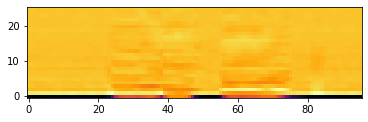

In [552]:
# TEST: Test shorter MFCC

idx = 0

# Create path from given filename and target item
path = join(dataset_path, target_list[int(y_orig_train[idx])], 
            filenames_train[idx])

# Create MFCCs
mfccs = calc_mfcc(path)
print("MFCCs:", mfccs)

# Plot MFCC
fig = plt.figure()
plt.imshow(mfccs, cmap='inferno', origin='lower')

# TEST: Play problem sounds
print(target_list[int(y_orig_train[idx])])

In [545]:
# Function: Create MFCCs, keeping only ones of desired length
def extract_features(in_files, in_y):
    prob_cnt = 0
    out_x = []
    out_y = []
        
    for index, filename in enumerate(in_files):
    
        # Create path from given filename and target item
        path = join(dataset_path, target_list[int(in_y[index])], 
                    filename)
        
        # Check to make sure we're reading a .wav file
        if not path.endswith('.wav'):
            continue

        # Create MFCCs
        mfccs = calc_mfcc(path)

        # Only keep MFCCs with given length
        if mfccs.shape[1] == len_mfcc:
            out_x.append(mfccs)
            out_y.append(in_y[index])
        else:
            print('Dropped:', index, mfccs.shape)
            prob_cnt += 1
            
    return out_x, out_y, prob_cnt

In [546]:
# Create train, validation, and test sets
x_train, y_train, prob = extract_features(filenames_train, 
                                          y_orig_train)
print('Removed percentage:', prob / len(y_orig_train))
x_val, y_val, prob = extract_features(filenames_val, y_orig_val)
print('Removed percentage:', prob / len(y_orig_val))
x_test, y_test, prob = extract_features(filenames_test, y_orig_test)
print('Removed percentage:', prob / len(y_orig_test))

Removed percentage: 0.0
Removed percentage: 0.0
Removed percentage: 0.0


In [547]:
# Save features and truth vector (y) sets to disk
np.savez(feature_sets_file, 
         x_train=x_train, 
         y_train=y_train, 
         x_val=x_val, 
         y_val=y_val, 
         x_test=x_test, 
         y_test=y_test)

In [548]:
# TEST: Load features
feature_sets = np.load(feature_sets_file)
feature_sets.files

['x_train', 'y_train', 'x_val', 'y_val', 'x_test', 'y_test']

In [549]:
len(feature_sets['x_train'])

5

In [550]:
'''
'Bom Kanan' 0, 
'Bom Kiri' 1, 
'Hidup' 2, 
'Jalan Kanan' 3, 
'Jalan Kiri' 4, 
'Lompat' 5, 
'Melompat Kanan' 6,
'Melompat Kiri' 7, 
'Nunduk'  8, 
'Tembak Atas' 9, 
'Tembak Kanan' 10, 
'Tembak Kiri' 11, 
'Tembak Nunduk' 12
'''

"\n'Bom Kanan' 0, \n'Bom Kiri' 1, \n'Hidup' 2, \n'Jalan Kanan' 3, \n'Jalan Kiri' 4, \n'Lompat' 5, \n'Melompat Kanan' 6,\n'Melompat Kiri' 7, \n'Nunduk'  8, \n'Tembak Atas' 9, \n'Tembak Kanan' 10, \n'Tembak Kiri' 11, \n'Tembak Nunduk' 12\n"

In [551]:
print(feature_sets['y_val'])

[11.  9.  8.  3.  5.  3. 12.  0.  8.  0.  6.  1.  4.  2.  6. 10.  4.  6.
  7.]
